# cLSTM Lorenz-96 Demo
- In this notebook, we train a cLSTM model on data simulated from a Lorenz-96 system

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from synthetic import simulate_lorenz_96
from models.clstm import cLSTM, train_model_ista
import pandas as pd

C:\Users\eserban\AppData\Roaming\Python\Python38\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# For GPU acceleration
device = 0 #torch.device('cuda')

In [3]:
data = pd.read_csv('./../TUTORIAL/dataset/double_pendulum_data_ORIGINAL_NORMALIZED.csv', delimiter=',', index_col=False, header=0)
    
data.columns.str.match("Unnamed")
data = data.loc[:,~data.columns.str.match("Unnamed")]
    
# Fill na with mean
for i in data.columns:
    mean_value = data[i].mean()
    data[i].fillna(value=mean_value, inplace=True)

In [4]:
data

,0,1,2,3,4,5,6,7
0,0.987464,0.493503,0.920531,1.000000,0.500039,0.514157,0.509739,0.499933
1,0.987464,0.493503,0.920531,1.000000,0.500039,0.514156,0.509739,0.499932
2,0.987464,0.493503,0.920531,1.000000,0.500039,0.514156,0.509739,0.499932
3,0.987464,0.493503,0.920531,1.000000,0.500039,0.514155,0.509739,0.499932
4,0.987464,0.493503,0.920531,1.000000,0.500039,0.514155,0.509739,0.499932
...,...,...,...,...,...,...,...,...
17562,0.818654,0.145605,0.481150,0.212124,0.727679,0.816785,0.620238,0.855509
17563,0.827591,0.155214,0.483312,0.222034,0.720622,0.821668,0.621282,0.853087
17564,0.827591,0.155214,0.483312,0.222034,0.720622,0.821668,0.621282,0.853087
17565,0.836250,0.164973,0.485492,0.231874,0.713773,0.826351,0.622121,0.850420


In [5]:
# Simulate data
X_np, GC = simulate_lorenz_96(p=8, F=8, T=17567)
X_np[:,0] = data['0'].values
X_np[:,1] = data['1'].values
X_np[:,2] = data['2'].values
X_np[:,3] = data['3'].values
X_np[:,4] = data['4'].values
X_np[:,5] = data['5'].values
X_np[:,6] = data['6'].values
X_np[:,7] = data['7'].values
X = torch.tensor(X_np[np.newaxis], dtype=torch.float32) #, device=device)

In [6]:
np.shape(X_np)

(17567, 8)

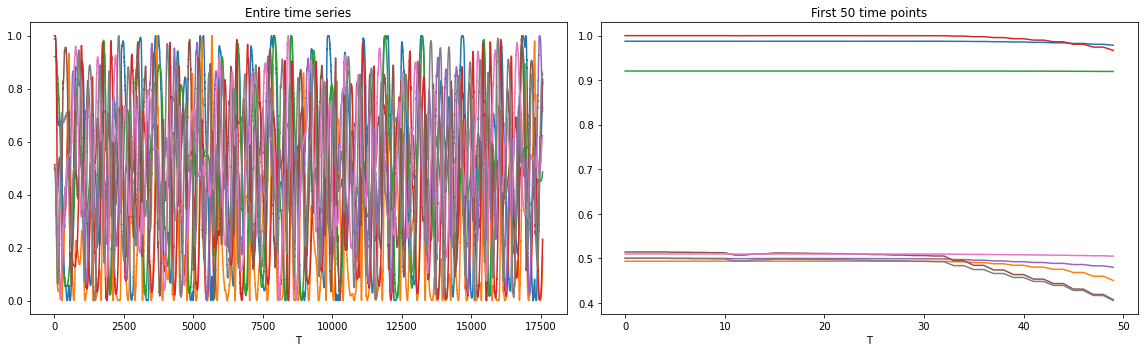

In [7]:
# Plot data
fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
axarr[0].plot(X_np)
axarr[0].set_xlabel('T')
axarr[0].set_title('Entire time series')
axarr[1].plot(X_np[:50])
axarr[1].set_xlabel('T')
axarr[1].set_title('First 50 time points')
plt.tight_layout()
plt.show()

In [8]:
# Set up model
clstm = cLSTM(X.shape[-1], hidden=100) #.cuda(device=device)

In [9]:
# Train with ISTA
train_loss_list = train_model_ista(
    clstm, X, context=10, lam=10.0, lam_ridge=1e-2, lr=1e-3, max_iter=8000,
    check_every=50)

KeyboardInterrupt: 

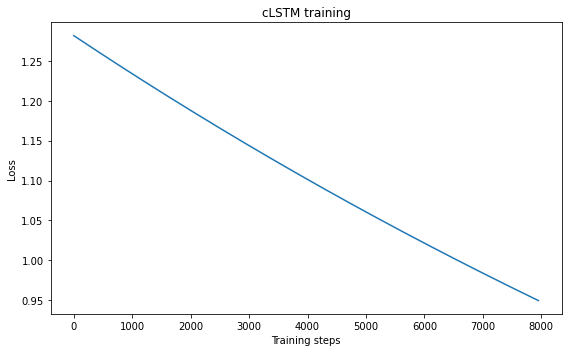

In [21]:
# Loss function plot
plt.figure(figsize=(8, 5))
plt.plot(50 * np.arange(len(train_loss_list)), train_loss_list)
plt.title('cLSTM training')
plt.ylabel('Loss')
plt.xlabel('Training steps')
plt.tight_layout()
plt.show()

True variable usage = 50.00%
Estimated variable usage = 0.00%
Accuracy = 50.00%


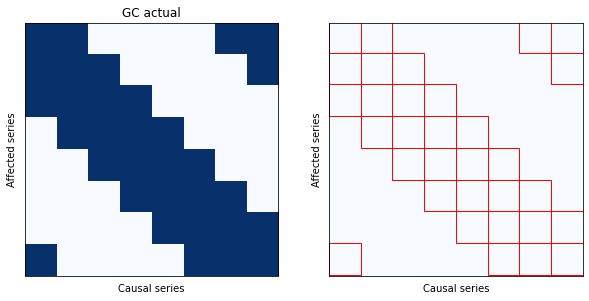

In [22]:
# Check learned Granger causality
GC_est = clstm.GC().cpu().data.numpy()

print('True variable usage = %.2f%%' % (100 * np.mean(GC)))
print('Estimated variable usage = %.2f%%' % (100 * np.mean(GC_est)))
print('Accuracy = %.2f%%' % (100 * np.mean(GC == GC_est)))

# Make figures
fig, axarr = plt.subplots(1, 2, figsize=(10, 5))
axarr[0].imshow(GC, cmap='Blues')
axarr[0].set_title('GC actual')
axarr[0].set_ylabel('Affected series')
axarr[0].set_xlabel('Causal series')
axarr[0].set_xticks([])
axarr[0].set_yticks([])

axarr[1].imshow(GC_est, cmap='Blues', vmin=0, vmax=1, extent=(0, len(GC_est), len(GC_est), 0))
axarr[1].set_ylabel('Affected series')
axarr[1].set_xlabel('Causal series')
axarr[1].set_xticks([])
axarr[1].set_yticks([])

# Mark disagreements
for i in range(len(GC_est)):
    for j in range(len(GC_est)):
        if GC[i, j] != GC_est[i, j]:
            rect = plt.Rectangle((j, i-0.05), 1, 1, facecolor='none', edgecolor='red', linewidth=1)
            axarr[1].add_patch(rect)

plt.show()